In [1]:
import sys
import os
from copy import deepcopy

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
import wandb

sys.path.append('..')

from src.configs import DataConfig, NetConfig, NetArchitecture, FilterConfig, DataType, CNNConfig, LC_SIZE
from src.utils import train, get_wandb_logger
from src.configs import PACKAGE_PATH
from src.data.data_processor import DataProcessor
from src.sweeps.sweep import DATA_CONFIG
from src.module.lightning_module import LCModule

In [6]:
data_cfg = deepcopy(DATA_CONFIG)
data_cfg.validation_path = f"{PACKAGE_PATH}/resources/SDLCD.csv"
data_cfg.data_types = [DataType.LC]

net_cfg = NetConfig(
    name="CNN_sweep", input_size=LC_SIZE, 
    class_names=data_cfg.class_names,
    output_size=len(data_cfg.class_names),
    architecture=NetArchitecture.CNN,
    learning_rate=0.001,
    args=CNNConfig(input_size=LC_SIZE, output_size=5, in_channels=1, 
                conv_layers=[(16,7, 5),(32, 3, 1)], 
                classifier_layers=[])
)

In [3]:
dp = DataProcessor(data_cfg)

if os.path.exists(f'{dp.output_path}/{dp.hash}'):
    dp.load_data_from_file()
    dp.load_data_from_file(test=True)
else:
    dp.create_dataset_from_csv()
    dp.save_data(test=True)
    dp.save_data()


In [7]:
from src.utils import get_wandb_logger

logger = get_wandb_logger("LC_TEST", "CNN3")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/k/kyselica12/.netrc


In [8]:
net_cfg.input_size = dp.data_shape()
module = LCModule(net_cfg)

train(module, dp,
    num_epochs=1000,
    batch_size=32,
    num_workers=4,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=15)],
    sampler=True,
    max_num_samples=20_000,
    logger=logger)

CNN middle dim: 480


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | net       | CNN              | 126 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
126 K     Trainable params
0         Non-trainable params
126 K     Total params
0.505     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 625/625 [00:05<00:00, 116.60it/s, v_num=ro2j, train_loss=0.0416, train_acc=1.000, val_loss=2.220, val_acc=0.560]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 10.10it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                  0.53125
        test_loss            2.393799066543579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
test_acc,▁
test_loss,▁
train_acc,▁▁▂▂▆▇▃▄▄▅▅▅▇▅▇▆▆▅▆▆▆▅▇▆▇▇▆▇▆▇▇▇█▇▇█▆▇▇█
train_loss,█▇▆▇▄▃▆▅▅▃▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▃▂▂▂▂▂▂▁▂▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▂▄▆▄▄█▆▆▆▆▆▆▆▆
val_loss,▁▁▂▂▃▃▄▃▅▅▆▆▆█▇█
epoch,16
test_acc,0.53125
test_loss,2.3938


In [1]:
import pandas as pd
import numpy as np
import pywt 
import matplotlib.pyplot as plt

# print("Computing Continuous Wavelet Transform....")
# lc = self.data[DT.LC]
# #TODO: Excange ZEROs with Recontructed values????
# scales = np.arange(1, self.wavelet_scales+1)
# coef, _ = pywt.cwt(lc ,scales,self.wavelet_name)
# coef = coef.transpose(1,0,2) # (N, scales, LC_SIZE)
# self.data[DT.WAVELET] = coef.reshape(len(lc),-1)

/tmp/ipykernel_8354/2524741145.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(f"../resources/SDLCD.csv")

In [13]:
arr = df.iloc[1].to_numpy()[4:].astype(np.float32)
arr = arr.reshape(1,300)

In [21]:
scales = np.arange(1, 150)
coef, _ = pywt.cwt(arr ,scales,'gaus1')
coef = coef.transpose(1,0,2) # (N, scales, LC_SIZE)
print(coef.shape)

(1, 149, 300)


(3.0, -1.5)

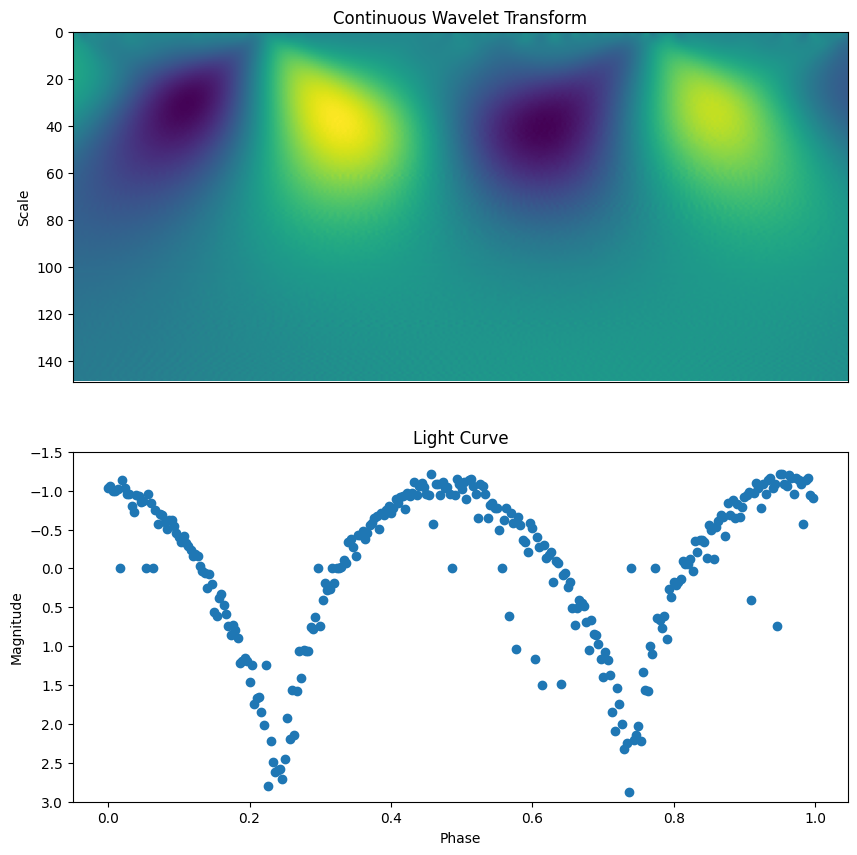

In [37]:
# set figure size
# plt.subplot(211)
# plt.imshow(coef[0])
# plt.xlabel('Time')
# plt.subplot(212)
# plt.scatter(np.arange(300)/300, arr[0])

# two plots in one figure
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].set_title('Continuous Wavelet Transform')
ax[0].imshow(coef[0],aspect='auto')
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Scale')
ax[0].set_ylim(150-1, 0)

ax[1].set_title('Light Curve')
ax[1].scatter(np.arange(300)/300, arr[0])
ax[1].set_xlabel('Phase')
ax[1].set_ylabel('Magnitude')
ax[1].set_ylim(3, -1.5)